In [6]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import MinMaxScaler

In [7]:
data_path = '../Datas/uschad_activity_dataset.h5'

In [8]:
with h5py.File(data_path, 'r') as f_r:
    data_genbylabel = f_r['data_genbylabel'][:]
    test_sample = data_genbylabel[100,:,1]
    print(data_genbylabel.shape)
    
    running_data = f_r['datas']['runningforward'][:]
    print(running_data.shape)

(28102, 100, 6)
(176500, 6)


In [14]:
scaler = MinMaxScaler()
data_fitted = scaler.fit_transform(running_data)
window = 100

num_splits = max((data_fitted.shape[0] - window + 1) // window, 0)
data_all = []

for i in range(num_splits):
    start = i * window
    end = (i + 1) * window
    data_all.append(data_fitted[start:end, :])
    
data_all = np.array(data_all)
print(data_all.shape)

(1764, 100, 6)


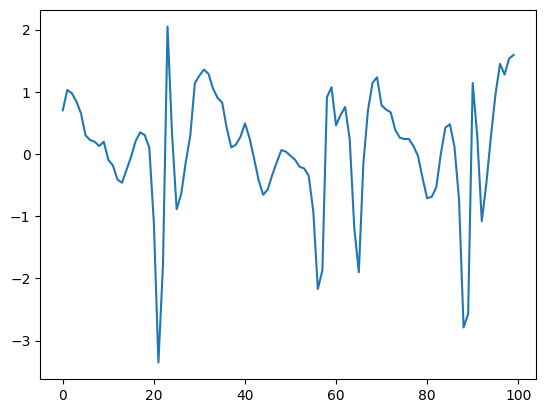

In [6]:
runningsample = running_data[100:200,1]
plt.plot(runningsample)

In [15]:
def norm_and_main_freq(x, k):
    print('check input shape', x.shape)
    # Apply FFT to get the frequency domain representation
    z = torch.fft.rfft(x, dim=2)
    # print('z shape', z.shape)
    
    # Find the top k largest magnitude frequency indices
    ks = torch.topk(z.abs(), k, dim=2)
    top_k_indices = ks.indices
    # print('check top k indices', top_k_indices.shape)
    
    # Create a mask for the top k frequencies
    mask = torch.zeros_like(z)
    mask.scatter_(2, top_k_indices, 1)  # Set top k frequency indices to 1
    
    # Apply mask to get the top k frequency components
    z_m = z * mask  # z_m contains only the top k frequency components
    
    # Get the remaining frequencies (by zeroing out the top k components)
    z_r = z * (1 - mask)  # z_r contains the remaining lower magnitude frequencies
    
    # Apply inverse FFT to bring the signals back to time domain
    x_m = torch.fft.irfft(z_m, dim=2).real  # Main frequency components
    x_r = torch.fft.irfft(z_r, dim=2).real  # Remaining part (without top k frequencies)
    
    # Return both components
    return x_r, x_m


In [21]:
input_tensor = torch.tensor(data_all[0:1000,:,:]).float().permute(0, 2, 1)
x_r, x_m = norm_and_main_freq(input_tensor, 3)
print(x_r.shape, x_m.shape)

check input shape torch.Size([1000, 6, 100])
torch.Size([1000, 6, 100]) torch.Size([1000, 6, 100])


In [22]:
x_m.shape

torch.Size([1000, 6, 100])

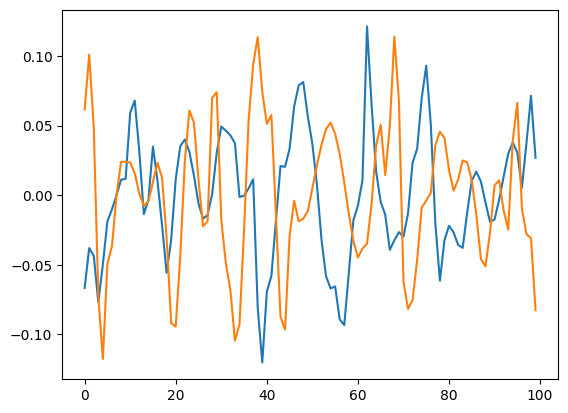

In [18]:

for i in range(40,42):
    plt.plot(x_r[i,5,:])
    # plt.plot(x_m[i,5,:])
    # plt.plot(data_all[i,:,5])
plt.show()

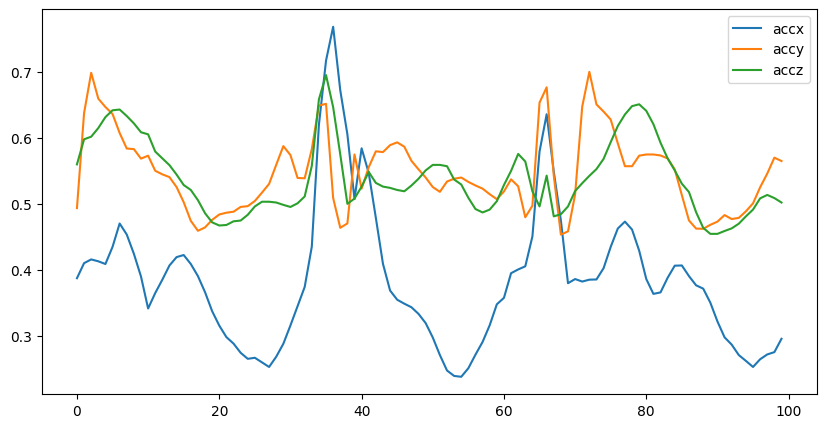

In [31]:
idx = 300
feature_id = 3
plt.figure(figsize=(10, 5))
# plt.plot(x_r[idx,0,:], label='resfreq_accx')
# plt.plot(x_r[idx,1,:], label='resfreq_accy')
# plt.plot(x_r[idx,2,:], label='resfreq_accz')

plt.plot(input_tensor[idx,0,:], label='accx')
plt.plot(input_tensor[idx,1,:], label='accy')
plt.plot(input_tensor[idx,2,:], label='accz')


# plt.plot(x_r[idx,feature_id,:], label='Remaining')
# plt.plot(x_m[idx,feature_id,:], label='Main')
# plt.plot(input_tensor[idx,feature_id,:], label='Original')
# plt.plot(x_r[idx,feature_id,:] + x_m[idx,feature_id,:], label='Reconstructed')
plt.legend()
plt.show()

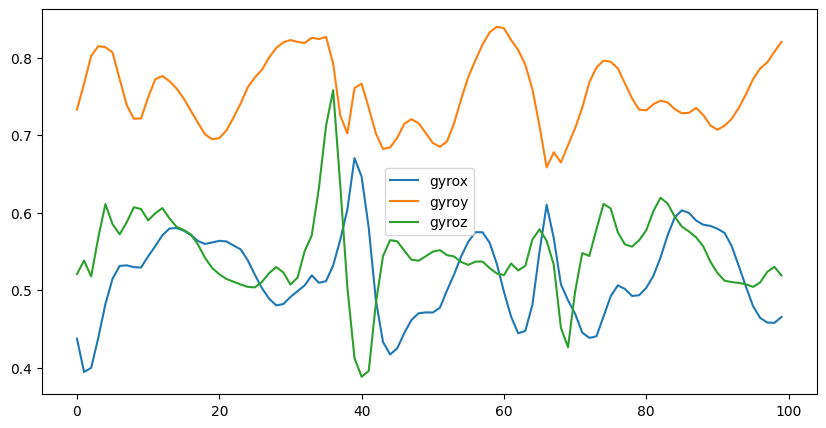

In [32]:
idx = 300
feature_id = 3
plt.figure(figsize=(10, 5))
# plt.plot(x_r[idx,3,:], label='resfreq_gyrox')
# plt.plot(x_r[idx,4,:], label='resfreq_gyroy')
# plt.plot(x_r[idx,5,:], label='resfreq_gyroz')

plt.plot(input_tensor[idx,3,:], label='gyrox')
plt.plot(input_tensor[idx,4,:], label='gyroy')
plt.plot(input_tensor[idx,5,:], label='gyroz')

# plt.plot(x_r[idx,feature_id,:], label='Remaining')
# plt.plot(x_m[idx,feature_id,:], label='Main')
# plt.plot(input_tensor[idx,feature_id,:], label='Original')
# plt.plot(x_r[idx,feature_id,:] + x_m[idx,feature_id,:], label='Reconstructed')
plt.legend()
plt.show()

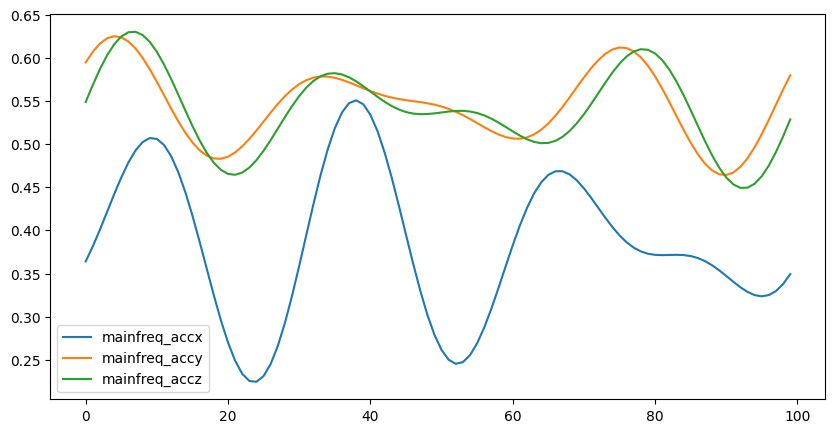

In [29]:
idx = 300
feature_id = 3
plt.figure(figsize=(10, 5))
plt.plot(x_m[idx,0,:], label='mainfreq_accx')
plt.plot(x_m[idx,1,:], label='mainfreq_accy')
plt.plot(x_m[idx,2,:], label='mainfreq_accz')

# plt.plot(x_r[idx,feature_id,:], label='Remaining')
# plt.plot(x_m[idx,feature_id,:], label='Main')
# plt.plot(input_tensor[idx,feature_id,:], label='Original')
# plt.plot(x_r[idx,feature_id,:] + x_m[idx,feature_id,:], label='Reconstructed')
plt.legend()
plt.show()

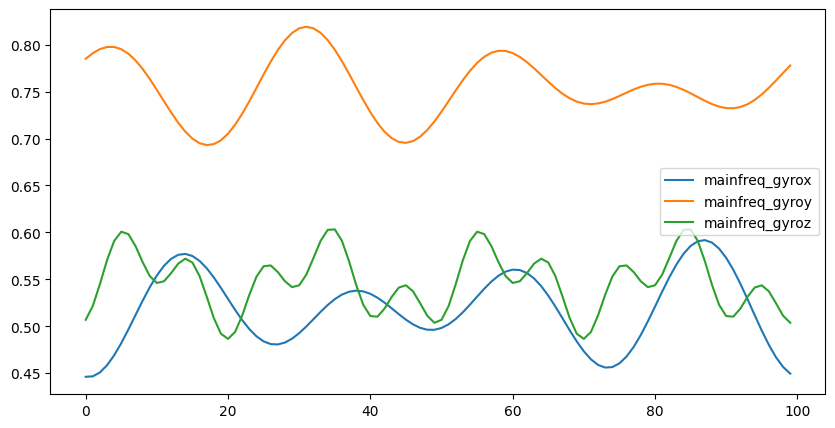

In [30]:
idx = 300
feature_id = 3
plt.figure(figsize=(10, 5))
plt.plot(x_m[idx,3,:], label='mainfreq_gyrox')
plt.plot(x_m[idx,4,:], label='mainfreq_gyroy')
plt.plot(x_m[idx,5,:], label='mainfreq_gyroz')

# plt.plot(x_r[idx,feature_id,:], label='Remaining')
# plt.plot(x_m[idx,feature_id,:], label='Main')
# plt.plot(input_tensor[idx,feature_id,:], label='Original')
# plt.plot(x_r[idx,feature_id,:] + x_m[idx,feature_id,:], label='Reconstructed')
plt.legend()
plt.show()

In [57]:
jumping_sample = jumping_data[1000:1100, :]
x_r, x_m = norm_and_main_freq(torch.tensor(jumping_sample).unsqueeze(0).float().permute(0,2,1), 5)
print(x_r.shape, x_m.shape)

check input shape torch.Size([1, 6, 100])
z shape torch.Size([1, 6, 51])
check top k indices torch.Size([1, 6, 5])
torch.Size([1, 6, 100]) torch.Size([1, 6, 100])


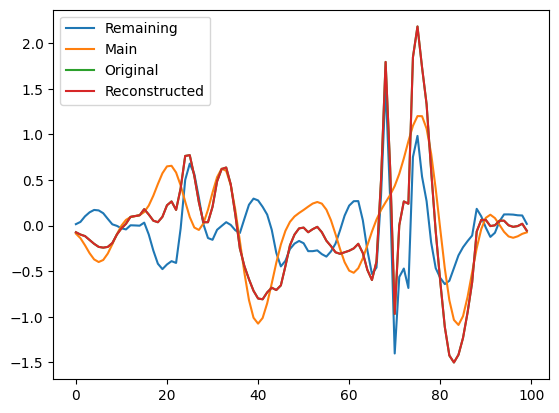

In [59]:
plt.plot(x_r[0,1,:], label='Remaining')
plt.plot(x_m[0,1,:], label='Main')
plt.plot(jumping_sample[:,1], label='Original')
plt.plot(x_r[0,1,:] + x_m[0,1,:], label='Reconstructed')
plt.legend()
plt.show()

In [1]:
import h5py
data_path_activity = '../Datas/uschad_activity_dataset.h5'
with h5py.File(data_path_activity, 'r') as f_r:
    dataset_genbylabel = f_r['datas']
    runningforward = dataset_genbylabel['jumping'][:]
print(runningforward.shape)

(107100, 6)


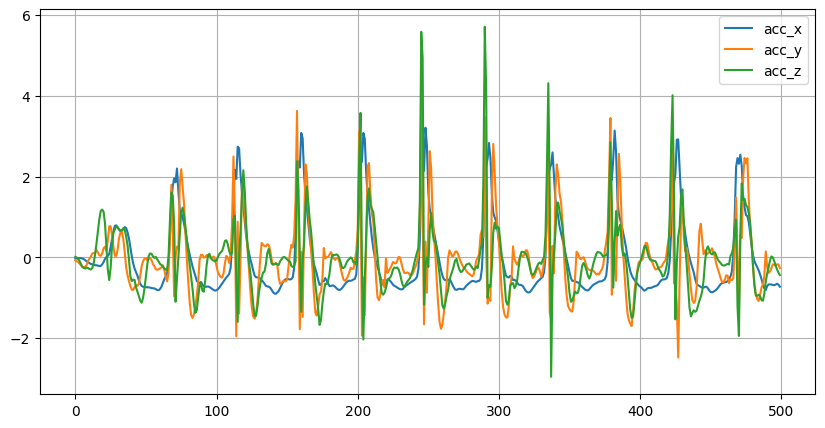

In [39]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
plt.plot(runningforward[1000:1500, 0], label='acc_x')
plt.plot(runningforward[1000:1500, 1], label='acc_y')
plt.plot(runningforward[1000:1500, 2], label='acc_z')
plt.legend()
plt.grid()
plt.show()

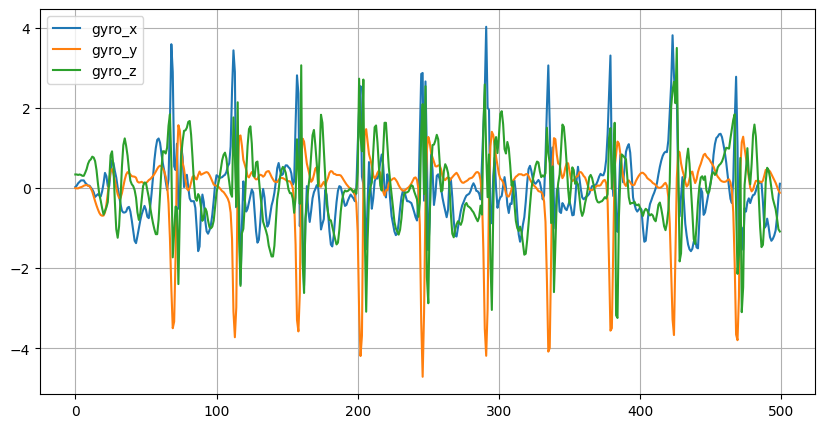

In [40]:
fig = plt.figure(figsize=(10, 5))
plt.plot(runningforward[1000:1500, 3], label='gyro_x')
plt.plot(runningforward[1000:1500, 4], label='gyro_y')
plt.plot(runningforward[1000:1500, 5], label='gyro_z')
plt.legend()
plt.grid()
plt.show()

In [33]:
from scipy.io import loadmat
mat_path = '../Datas/a2t2.mat'
mat_data = loadmat(mat_path)
print(mat_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'title', 'version', 'date', 'subject', 'age', 'height', 'weight', 'activity', 'activity_number', 'trial', 'sensor_location', 'sensor_orientation', 'sensor_readings'])


In [34]:
print(mat_data['activity'])

['walking-left']


In [35]:
sensor = mat_data['sensor_readings']

In [36]:
sensor.shape

(2000, 6)

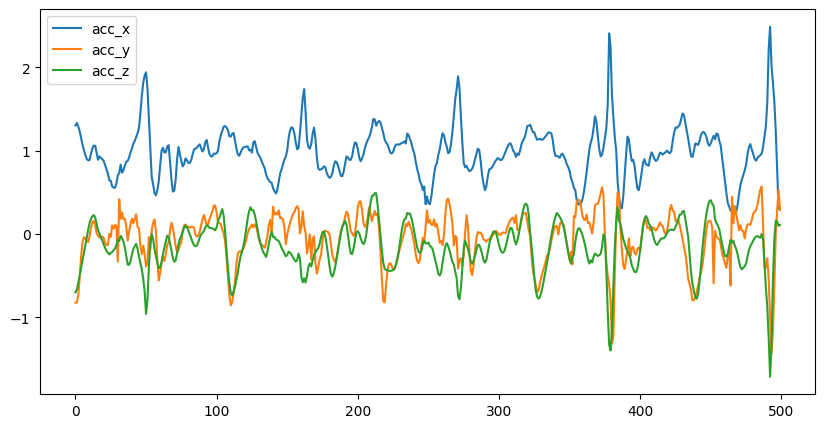

In [38]:
fig = plt.figure(figsize=(10, 5))
plt.plot(sensor[1000:1500, 0], label='acc_x')
plt.plot(sensor[1000:1500, 1], label='acc_y')
plt.plot(sensor[1000:1500, 2], label='acc_z')
# plt.plot(sensor[1000:1500, 3], label='gyro_x')
# plt.plot(sensor[1000:1500, 4], label='gyro_y')
# plt.plot(sensor[1000:1500, 5], label='gyro_z')
plt.legend()
plt.show()

In [5]:
import matplotlib.pyplot as plt
import torch

# Your norm_and_main_freq function to separate high and low frequencies
def norm_and_main_freq(x, k):
    print('check input shape', x.shape)
    # Apply FFT to get the frequency domain representation
    z = torch.fft.rfft(x, dim=2)
    
    # Find the top k largest magnitude frequency indices
    ks = torch.topk(z.abs(), k, dim=2)
    top_k_indices = ks.indices
    
    # Create a mask for the top k frequencies
    mask = torch.zeros_like(z)
    mask.scatter_(2, top_k_indices, 1)  # Set top k frequency indices to 1
    
    # Apply mask to get the top k frequency components
    z_m = z * mask  # z_m contains only the top k frequency components
    
    # Get the remaining frequencies (by zeroing out the top k components)
    z_r = z * (1 - mask)  # z_r contains the remaining lower magnitude frequencies
    
    # Apply inverse FFT to bring the signals back to time domain
    x_m = torch.fft.irfft(z_m, dim=2).real  # Main frequency components
    x_r = torch.fft.irfft(z_r, dim=2).real  # Remaining part (without top k frequencies)
    
    # Return both components
    return x_r, x_m

# Assuming runningforward is your original data in (n, 3) shape
# Convert runningforward to (1, n, 3) shape for the function
runningforward_tensor = torch.tensor(runningforward[:, :], dtype=torch.float32)
k = 5  # Number of main frequencies to keep
print(runningforward_tensor.shape)
# Get low-frequency (remaining) and high-frequency (main) components
x_r, x_m = norm_and_main_freq(runningforward_tensor, k)

# Convert tensors back to numpy arrays for plotting
x_r = x_r.squeeze().numpy()
x_m = x_m.squeeze().numpy()

# Plot the low-frequency part
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].plot(x_r[1000:1500, 0], label='Low Freq - acc_x')
ax[0].plot(x_r[1000:1500, 1], label='Low Freq - acc_y')
ax[0].plot(x_r[1000:1500, 2], label='Low Freq - acc_z')
ax[0].legend()
ax[0].set_title("Low Frequency Components")
ax[0].grid()

# Plot the high-frequency part
ax[1].plot(x_m[1000:1500, 0], label='High Freq - acc_x')
ax[1].plot(x_m[1000:1500, 1], label='High Freq - acc_y')
ax[1].plot(x_m[1000:1500, 2], label='High Freq - acc_z')
ax[1].legend()
ax[1].set_title("High Frequency Components")
ax[1].grid()

plt.tight_layout()
plt.show()


torch.Size([107100, 6])
check input shape torch.Size([107100, 6])


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

check activity shape walkingforward (1270, 300, 6)
check freq magnitude shape torch.Size([1270, 151])
check activity shape walkingleft (861, 300, 6)
check freq magnitude shape torch.Size([861, 151])
check activity shape walkingright (917, 300, 6)
check freq magnitude shape torch.Size([917, 151])
check activity shape walkingupstairs (705, 300, 6)
check freq magnitude shape torch.Size([705, 151])
check activity shape walkingdownstairs (657, 300, 6)
check freq magnitude shape torch.Size([657, 151])
check activity shape runningforward (587, 300, 6)
check freq magnitude shape torch.Size([587, 151])
check activity shape jumping (356, 300, 6)
check freq magnitude shape torch.Size([356, 151])
check activity shape sitting (870, 300, 6)
check freq magnitude shape torch.Size([870, 151])
check activity shape standing (785, 300, 6)
check freq magnitude shape torch.Size([785, 151])
check activity shape sleeping (1249, 300, 6)
check freq magnitude shape torch.Size([1249, 151])
check activity shape el

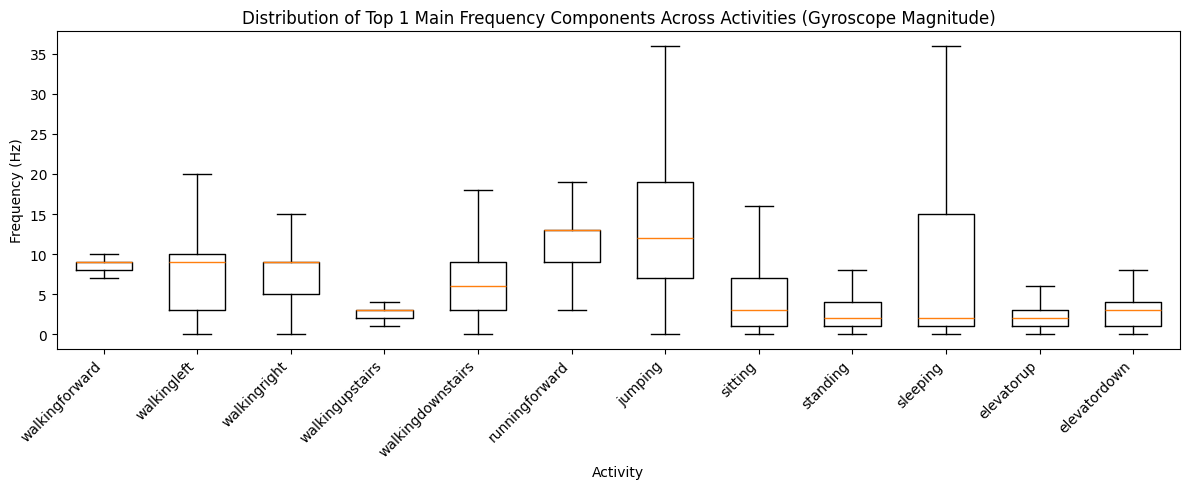

In [45]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import MinMaxScaler

def window_data(data, window):
    scaler = MinMaxScaler()
    data_fitted = scaler.fit_transform(data)
    window = 300

    num_splits = max((data_fitted.shape[0] - window + 1) // window, 0)
    data_all = []

    for i in range(num_splits):
        start = i * window
        end = (i + 1) * window
        data_all.append(data_fitted[start:end, :])
        
    data_all = np.array(data_all)
    return data_all

def calculate_main_frequencies(data, k=2):
    """
    Calculate the top-k main frequency components for each channel in the data.
    """

    data_tensor = torch.tensor(data, dtype=torch.float32)
    acc_data = data_tensor[:, :, 3:]  # Extract accelerometer data
    acc_magnitude = torch.sqrt((acc_data ** 2).sum(dim=2))  # Calculate magnitude of accelerometer data
    acc_magnitude = acc_magnitude - acc_magnitude.mean(dim=1, keepdim=True)
    
    hanning_window = torch.hann_window(acc_magnitude.shape[1]).to(acc_magnitude.device)
    acc_magnitude_windowed = acc_magnitude * hanning_window
    
    # Convert data to torch tensor for FFT
    # data_tensor = torch.tensor(data, dtype=torch.float32)
    
    # Apply FFT along the time dimension (dim=1)
    freq_data = torch.fft.rfft(acc_magnitude_windowed, dim=1)
    # Get the magnitude of each frequency component
    freq_magnitude = freq_data.abs()
    print('check freq magnitude shape', freq_magnitude.shape)
    # plt.plot(freq_magnitude[1400, :].cpu().numpy())
#     print(freq_magnitude)
    
#     # Identify the top-k frequencies for each channel
    top_k_freqs = torch.topk(freq_magnitude, k, dim=1).indices.cpu().numpy()
#     print(top_k_freqs)
    
    return top_k_freqs

# # Path to your dataset
data_path = '../Datas/uschad_activity_dataset.h5'
activity_label = {
    'walkingforward': 1,
    'walkingleft': 2,
    'walkingright': 3,
    'walkingupstairs': 4,
    'walkingdownstairs': 5,
    'runningforward': 6,
    'jumping': 7,
    'sitting': 8,
    'standing': 9,
    'sleeping': 10,
    'elevatorup': 11,
    'elevatordown': 12
}
# Dictionary to store main frequencies for each activity
activity_main_freqs = {}

# Load each activity's data and calculate main frequencies for each sample
with h5py.File(data_path, 'r') as f_r:
    for activity, label in activity_label.items():
        activity_data = f_r['datas'][activity][:]
        activity_data = window_data(activity_data, 100)
        print('check activity shape', activity, activity_data.shape)
        
        main_freqs = calculate_main_frequencies(activity_data, k=1)  # Shape: (n, k, 6)
        # Reshape main frequencies for easier plotting in boxplot
        main_freqs_flattened = main_freqs.flatten()
        # print('main freqs flattened shape',main_freqs_flattened.shape)
        # Store flattened main frequencies for each activity
        activity_main_freqs[activity] = main_freqs_flattened

# Plotting the main frequencies for each activity as a box plot
fig, ax = plt.subplots(figsize=(12, 5))

# Prepare box plot data
box_data = [activity_main_freqs[activity] for activity in activity_label.keys()]
print(box_data)
ax.boxplot(box_data, widths=0.6, showfliers=False)

# Set axis labels and title
ax.set_xticks(range(1, len(activity_label) + 1))
ax.set_xticklabels(activity_label.keys(), rotation=45, ha="right")
ax.set_title("Distribution of Top 1 Main Frequency Components Across Activities (Gyroscope Magnitude)")
ax.set_xlabel("Activity")
ax.set_ylabel("Frequency (Hz)")

plt.tight_layout()
plt.show()
